In [220]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as sp

x = np.load('X_77.npy', allow_pickle = True)
y = np.load('y_77.npy', allow_pickle = True)
a = np.load('alphas_77.npy', allow_pickle = True)

# 3. Constructing the matrix X #

In [231]:
def construct_X(M, alpha, Np = None):
    h = 1
    #Convert alpha to radians
    alpha  = alpha*np.pi/180.0
    #Define Np in case is none
    if Np is None:
        Np = int(sqrt(2)*M)
        if Np%2 == 0:
            Np += Np
        
    #Normal Vector defining orientation and centers of pixels
    n = np.stack((np.cos(alpha),np.sin(alpha))).transpose()
    centers = np.mgrid[0:M,0:M]*h
    #Move the coordintates to the origin, which is on the center
    c_x = centers[0].flatten()-int(M/2)*h
    c_y = centers[1].flatten()-int(M/2)*h
    centers_flat = np.stack((c_x,c_y))
    
    #calculate distance as projection and determine previous and next pixel of the sensor
    projection = np.matmul(n,centers_flat)+int(Np/2)*h
    previous_pixel = np.floor(projection)
    next_pixel = previous_pixel+1
    
    weight_previous = (next_pixel-projection)/h
    weight_next = (projection-previous_pixel)/h
    
    j_index = previous_pixel+Np*np.arange(len(alpha))[:,np.newaxis]
    j_next_index = next_pixel+Np*np.arange(len(alpha))[:,np.newaxis]
    
    weight = np.concatenate((weight_previous.flatten(),weight_next.flatten()))
    j = np.concatenate((j_index.flatten(),j_next_index.flatten()))
    
    i = (centers[0]+M*centers[1]).flatten()
    #Repeat the i for each angle times two (because one image pixel affects two sensor pixel)
    i = np.tile(i,2*len(alpha)).flatten()
    D = M**2
    X = sparse.coo_matrix((weight,(j,i)), shape = (Np*len(alpha),D), dtype = np.float32)
    return X

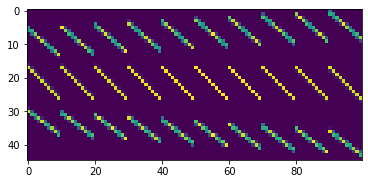

In [232]:
M = 10
Np = 15
a_test = np.array([-33,1,42])
test = construct_X(M,a_test,Np)
plt.imshow(test.todense())

(45, 100)


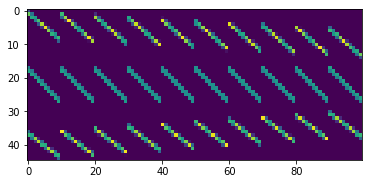

In [223]:
X_s = np.load('X_example.npy', allow_pickle = True)
print(X_s.shape)
plt.imshow(X_s)

# 4. Reconstructing the Image #

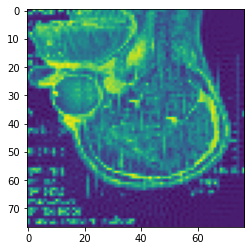

In [233]:
M = 77
Np = 109
X_img = construct_X(M,a,Np)
img = sp.lsqr(X_img,y,atol = 1e-5,btol = 1e-5)[0]
img = np.reshape(img,(M,M))
plt.imshow(img)

The patient has a crayon stuck in his brain


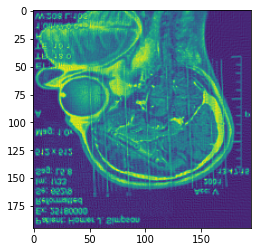

In [235]:
y_true = np.load('y_195.npy', allow_pickle = True)
a_true = np.load('alphas_195.npy', allow_pickle = True)
M = 195
Np = 275
X_img = construct_X(M,a_true,Np)
img = sp.lsqr(X_img,y_true,atol = 1e-5,btol = 1e-5)[0]
img = np.reshape(img,(M,M))
plt.imshow(img)
print('The patient has a crayon stuck in his brain')

# 5. Minimizing the dose #

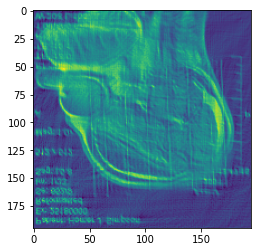

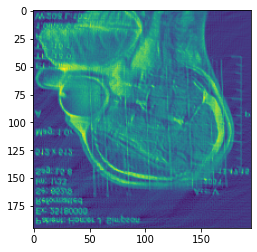

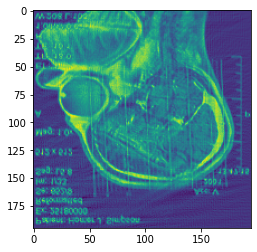

In [246]:
n = [100,125,150]
for N in n:
    a_red = a_true[0:N]
    y_red = y_true[0:N*Np]
    X_img = construct_X(M,a_red,Np)
    img = sp.lsqr(X_img,y_red,atol = 1e-5,btol = 1e-5)[0]
    img = np.reshape(img,(M,M))
    plt.figure()
    plt.imshow(img)
print('We observe that for 125 projection angles there is some hint of the crayon, and for 150 angles we can clearly resolve it')